# Does Harry Browne's permanent portfolio withstand the test of time?

## Python Imports

In [1]:
# Standard Library
import datetime
import io
import os
import random
import sys
import warnings
from pathlib import Path

# Data Handling
import numpy as np
import pandas as pd

# Data Visualization
import matplotlib.dates as mdates
import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns
from matplotlib.ticker import FormatStrFormatter, FuncFormatter, MultipleLocator

# Data Sources
import yfinance as yf

# Statistical Analysis
import statsmodels.api as sm

# Machine Learning
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# Suppress warnings
warnings.filterwarnings("ignore")

## Add Directories To Path

In [2]:
# Add the source subdirectory to the system path to allow import config from settings.py
current_directory = Path(os.getcwd())
website_base_directory = current_directory.parent.parent.parent
src_directory = website_base_directory / "src"
sys.path.append(str(src_directory)) if str(src_directory) not in sys.path else None

# Import settings.py
from settings import config

# Add configured directories from config to path
SOURCE_DIR = config("SOURCE_DIR")
sys.path.append(str(Path(SOURCE_DIR))) if str(Path(SOURCE_DIR)) not in sys.path else None

QUANT_FINANCE_RESEARCH_BASE_DIR = config("QUANT_FINANCE_RESEARCH_BASE_DIR")
sys.path.append(str(Path(QUANT_FINANCE_RESEARCH_BASE_DIR))) if str(Path(QUANT_FINANCE_RESEARCH_BASE_DIR)) not in sys.path else None

QUANT_FINANCE_RESEARCH_SOURCE_DIR = config("QUANT_FINANCE_RESEARCH_SOURCE_DIR")
sys.path.append(str(Path(QUANT_FINANCE_RESEARCH_SOURCE_DIR))) if str(Path(QUANT_FINANCE_RESEARCH_SOURCE_DIR)) not in sys.path else None

# Add other configured directories
BASE_DIR = config("BASE_DIR")
CONTENT_DIR = config("CONTENT_DIR")
POSTS_DIR = config("POSTS_DIR")
PAGES_DIR = config("PAGES_DIR")
PUBLIC_DIR = config("PUBLIC_DIR")
SOURCE_DIR = config("SOURCE_DIR")
DATA_DIR = config("DATA_DIR")

# Print system path
for i, path in enumerate(sys.path):
    print(f"{i}: {path}")

0: /usr/lib/python313.zip
1: /usr/lib/python3.13
2: /usr/lib/python3.13/lib-dynload
3: 
4: /home/jared/python-virtual-envs/general_313/lib/python3.13/site-packages
5: /home/jared/Cloud_Storage/Dropbox/Websites/jaredszajkowski.github.io/src
6: /home/jared/Cloud_Storage/Dropbox/Quant_Finance_Research
7: /home/jared/Cloud_Storage/Dropbox/Quant_Finance_Research/src


## Track Index Dependencies

In [3]:
# Create file to track markdown dependencies
dep_file = Path("index_dep.txt")
dep_file.write_text("")

0

# Python Functions

### Typical Functions

In [4]:
# Import functions from source directories
from export_track_md_deps import export_track_md_deps
from df_info import df_info
from df_info_markdown import df_info_markdown
from pandas_set_decimal_places import pandas_set_decimal_places
from load_data import load_data

### Project Specific Functions

#### Bloomberg Data Updater

In [5]:
# This function takes an excel export from Bloomberg and 
# removes all excess data leaving date and close columns

# Imports
import pandas as pd

# Function definition
def bb_data_updater(fund):

    # File name variable
    file = fund + ".xlsx"
    
    # Import data from file as a pandas dataframe
    df = pd.read_excel(file, sheet_name = 'Worksheet', engine='openpyxl')
    
    # Set the column headings from row 5 (which is physically row 6)
    df.columns = df.iloc[5]
    
    # Set the column heading for the index to be "None"
    df.rename_axis(None, axis=1, inplace = True)
    
    # Drop the first 6 rows, 0 - 5
    df.drop(df.index[0:6], inplace=True)
    
    # Set the date column as the index
    df.set_index('Date', inplace = True)
    
    # Drop the volume column
    try:
        df.drop(columns = {'PX_VOLUME'}, inplace = True)
    except KeyError:
        pass
        
    # Rename column
    df.rename(columns = {'PX_LAST':'Close'}, inplace = True)
    
    # Sort by date
    df.sort_values(by=['Date'], inplace = True)
    
    # Export data to excel
    file = fund + "_Clean.xlsx"
    df.to_excel(file, sheet_name='data')
    
    # Output confirmation
    print(f"The last date of data for {fund} is: ")
    print(df[-1:])
    print(f"Bloomberg data conversion complete for {fund} data")
    return print(f"--------------------")

#### Strategy Function

In [6]:
def strategy(
    fund_list: str, 
    starting_cash: int, 
    cash_contrib: int, 
    close_prices_df: pd.DataFrame, 
    rebal_month: int, 
    rebal_day: int, 
    rebal_per_high: float, 
    rebal_per_low: float,
) -> pd.DataFrame:
    """
    Execute the rebalance strategy based on specified criteria.

    Parameters:
    -----------
    fund_list (str):
        List of funds for data to be combined from. Funds are strings in the form "BTC-USD".
    starting_cash (int):
        Starting investment balance.
    cash_contrib (int):
        Cash contribution to be made daily.
    close_prices_df (pd.DataFrame):
        DataFrame containing date and close prices for all funds to be included.
    rebal_month (int):
        Month for annual rebalance.
    rebal_day (int):
        Day for annual rebalance.
    rebal_per_high (float):
        High percentage for rebalance.
    rebal_per_low (float):
        Low percentage for rebalance.

    Returns:
    --------
    df (pd.DataFrame):
        DataFrame containing strategy data for all funds to be included. Also dumps the df to excel for reference later.
    """

    num_funds = len(fund_list)

    df = close_prices_df.copy()
    df.reset_index(inplace = True)

    # Date to be used for annual rebalance
    target_month = rebal_month
    target_day = rebal_day

    # Create a dataframe with dates from the specific month
    rebal_date = df[df['Date'].dt.month == target_month]

    # Specify the date or the next closest
    rebal_date = rebal_date[rebal_date['Date'].dt.day >= target_day]

    # Group by year and take the first entry for each year
    rebal_dates_by_year = rebal_date.groupby(rebal_date['Date'].dt.year).first().reset_index(drop=True)

    '''
    Column order for the dataframe:
    df[fund + "_BA_Shares"]
    df[fund + "_BA_$_Invested"]
    df[fund + "_BA_Port_%"]
    df['Total_BA_$_Invested']
    df['Contribution']
    df['Rebalance']
    df[fund + "_AA_Shares"]
    df[fund + "_AA_$_Invested"]
    df[fund + "_AA_Port_%"]
    df['Total_AA_$_Invested']
    '''

    # Calculate the columns and initial values for before action (BA) shares, $ invested, and port %
    for fund in fund_list:
        df[fund + "_BA_Shares"] = starting_cash / num_funds / df[fund + "_Close"]
        df[fund + "_BA_$_Invested"] = df[fund + "_BA_Shares"] * df[fund + "_Close"]
        df[fund + "_BA_Port_%"] = 0.25

    # Set column values initially
    df['Total_BA_$_Invested'] = starting_cash
    df['Contribution'] = 0
    # df['Contribution'] = cash_contrib
    df['Rebalance'] = "No"

    # Set columns and values initially for after action (AA) shares, $ invested, and port %
    for fund in fund_list:
        df[fund + "_AA_Shares"] = starting_cash / num_funds / df[fund + "_Close"]
        df[fund + "_AA_$_Invested"] = df[fund + "_AA_Shares"] * df[fund + "_Close"]
        df[fund + "_AA_Port_%"] = 0.25
        
    # Set column value for after action (AA) total $ invested
    df['Total_AA_$_Invested'] = starting_cash

    # Iterate through the dataframe and execute the strategy
    for index, row in df.iterrows():

        # Ensure there's a previous row to reference by checking the index value
        if index > 0:

            # Initialize variable
            Total_BA_Invested = 0

            # Calculate before action (BA) shares and $ invested values
            for fund in fund_list:
                df.at[index, fund + "_BA_Shares"] = df.at[index - 1, fund + "_AA_Shares"]
                df.at[index, fund + "_BA_$_Invested"] = df.at[index, fund + "_BA_Shares"] * row[fund + "_Close"]

                # Sum the asset values to find the total
                Total_BA_Invested = Total_BA_Invested + df.at[index, fund + "_BA_$_Invested"]

            # Calculate before action (BA) port % values
            for fund in fund_list:
                df.at[index, fund + "_BA_Port_%"] = df.at[index, fund + "_BA_$_Invested"] / Total_BA_Invested

            # Set column for before action (BA) total $ invested
            df.at[index, 'Total_BA_$_Invested'] = Total_BA_Invested

            # Initialize variables
            rebalance = "No"
            date = row['Date']

            # Check for a specific date annually
            # Simple if statement to check if date_to_check is in jan_28_or_after_each_year
            if date in rebal_dates_by_year['Date'].values:
                rebalance = "Yes"
            else:
                pass

            # Check to see if any asset has portfolio percentage of greater than 35% or less than 15% and if so set variable
            for fund in fund_list:
                if df.at[index, fund + "_BA_Port_%"] > rebal_per_high or df.at[index, fund + "_BA_Port_%"] < rebal_per_low:
                    rebalance = "Yes"
                else:
                    pass

            # If rebalance is required, rebalance back to 25% for each asset, else just divide contribution evenly across assets
            if rebalance == "Yes":
                df.at[index, 'Rebalance'] = rebalance
                for fund in fund_list:
                        df.at[index, fund + "_AA_$_Invested"] = (Total_BA_Invested + df.at[index, 'Contribution']) * 0.25
            else:
                df.at[index, 'Rebalance'] = rebalance
                for fund in fund_list:
                        df.at[index, fund + "_AA_$_Invested"] = df.at[index, fund + "_BA_$_Invested"] + df.at[index, 'Contribution'] * 0.25

            # Initialize variable
            Total_AA_Invested = 0

            # Set column values for after action (AA) shares and port %
            for fund in fund_list:
                df.at[index, fund + "_AA_Shares"] = df.at[index, fund + "_AA_$_Invested"] / row[fund + "_Close"]

                # Sum the asset values to find the total
                Total_AA_Invested = Total_AA_Invested + df.at[index, fund + "_AA_$_Invested"]

            # Calculate after action (AA) port % values
            for fund in fund_list:
                df.at[index, fund + "_AA_Port_%"] = df.at[index, fund + "_AA_$_Invested"] / Total_AA_Invested

            # Set column for after action (AA) total $ invested
            df.at[index, 'Total_AA_$_Invested'] = Total_AA_Invested

        # If this is the first row
        else:
            pass

    df['Return'] = df['Total_AA_$_Invested'].pct_change()
    df['Cumulative_Return'] = (1 + df['Return']).cumprod()

    plan_name = '_'.join(fund_list)
    file = plan_name + "_Strategy.xlsx"
    location = file
    df.to_excel(location, sheet_name="data")
    print(f"Strategy complete for {plan_name}.")
    return df

#### Summary Stats

In [7]:
# Stats for entire data set
def summary_stats(
    fund_list: str, 
    df: pd.DataFrame, 
    period: str,
    excel_export: bool,
) -> pd.DataFrame:
    
    """
    Calculate summary statistics for the given fund list and return data.

    Parameters:
    -----------
    fund_list (str):
        List of funds for data to be combined from. Funds are strings in the form "BTC-USD".
    df (pd.DataFrame):
        Dataframe with return data.
    period (str):
        Period for which to calculate statistics. Options are "Monthly", "Weekly", "Daily", "Hourly".
    excel_export (bool):
        If True, export to excel file.

    Returns:
    --------
    df_stats (pd.DataFrame):
        pd.DataFrame: DataFrame containing various portfolio statistics.
    """

    if period == "Monthly":
        timeframe = 12 # months
    elif period == "Weekly":
        timeframe = 52 # weeks
    elif period == "Daily":
        timeframe = 365 # days
    elif period == "Hourly":
        timeframe = 8760 # hours
    else:
        return print("Error, check inputs")

    df_stats = pd.DataFrame(df.mean(axis=0) * timeframe) # annualized
    # df_stats = pd.DataFrame((1 + df.mean(axis=0)) ** timeframe - 1) # annualized, this is this true annualized return but we will simply use the mean
    df_stats.columns = ['Annualized Mean']
    df_stats['Annualized Volatility'] = df.std() * np.sqrt(timeframe) # annualized
    df_stats['Annualized Sharpe Ratio'] = df_stats['Annualized Mean'] / df_stats['Annualized Volatility']

    df_cagr = (1 + df['Return']).cumprod()
    cagr = (df_cagr.iloc[-1] / 1) ** (1/(len(df_cagr) / timeframe)) - 1
    df_stats['CAGR'] = cagr

    df_stats[period + ' Max Return'] = df.max()
    df_stats[period + ' Max Return (Date)'] = df.idxmax().values[0]
    df_stats[period + ' Min Return'] = df.min()
    df_stats[period + ' Min Return (Date)'] = df.idxmin().values[0]
    
    wealth_index = 1000*(1+df).cumprod()
    previous_peaks = wealth_index.cummax()
    drawdowns = (wealth_index - previous_peaks)/previous_peaks

    df_stats['Max Drawdown'] = drawdowns.min()
    df_stats['Peak'] = [previous_peaks[col][:drawdowns[col].idxmin()].idxmax() for col in previous_peaks.columns]
    df_stats['Bottom'] = drawdowns.idxmin()

    recovery_date = []
    for col in wealth_index.columns:
        prev_max = previous_peaks[col][:drawdowns[col].idxmin()].max()
        recovery_wealth = pd.DataFrame([wealth_index[col][drawdowns[col].idxmin():]]).T
        recovery_date.append(recovery_wealth[recovery_wealth[col] >= prev_max].index.min())
    df_stats['Recovery Date'] = recovery_date

    plan_name = '_'.join(fund_list)

    # Export to excel
    if excel_export == True:
        
        file = plan_name + "_Summary_Stats.xlsx"
        location = file
        # location = f"{base_directory}/{strategy_name}/{file_name}.xlsx"
        df_stats.to_excel(location, sheet_name="data")
    else:
        pass

    print(f"Summary stats complete for {plan_name}.")
    return df_stats

### plot_cumulative_return

In [8]:
def plot_cumulative_return(strat_df):
    # Generate plot
    plt.figure(figsize=(10, 5), facecolor = '#F5F5F5')

    # Plotting data
    plt.plot(strat_df.index, strat_df['Cumulative_Return'], label = 'Strategy Cumulative Return', linestyle='-', color='green', linewidth=1)
    
    # Set X axis
    # x_tick_spacing = 5  # Specify the interval for x-axis ticks
    # plt.gca().xaxis.set_major_locator(MultipleLocator(x_tick_spacing))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xlabel('Year', fontsize = 9)
    plt.xticks(rotation = 45, fontsize = 7)
    # plt.xlim(, )

    # Set Y axis
    y_tick_spacing = 0.5  # Specify the interval for y-axis ticks
    plt.gca().yaxis.set_major_locator(MultipleLocator(y_tick_spacing))
    plt.ylabel('Cumulative Return', fontsize = 9)
    plt.yticks(fontsize = 7)
    # plt.ylim(0, 7.5)

    # Set title, etc.
    plt.title('Cumulative Return', fontsize = 12)
    
    # Set the grid & legend
    plt.tight_layout()
    plt.grid(True)
    plt.legend(fontsize=8)

    # Save the figure
    plt.savefig('03_Cumulative_Return.png', dpi=300, bbox_inches='tight')

    # Display the plot
    return plt.show()

### plot_values

In [9]:
def plot_values(strat_df):   
    # Generate plot   
    plt.figure(figsize=(10, 5), facecolor = '#F5F5F5')
    
    # Plotting data
    plt.plot(strat_df.index, strat_df['Total_AA_$_Invested'], label='Total Portfolio Value', linestyle='-', color='black', linewidth=1)
    plt.plot(strat_df.index, strat_df['Stocks_AA_$_Invested'], label='Stocks Position Value', linestyle='-', color='orange', linewidth=1)
    plt.plot(strat_df.index, strat_df['Bonds_AA_$_Invested'], label='Bond Position Value', linestyle='-', color='yellow', linewidth=1)
    plt.plot(strat_df.index, strat_df['Gold_AA_$_Invested'], label='Gold Position Value', linestyle='-', color='blue', linewidth=1)
    plt.plot(strat_df.index, strat_df['Cash_AA_$_Invested'], label='Cash Position Value', linestyle='-', color='brown', linewidth=1)

    # Set X axis
    # x_tick_spacing = 5  # Specify the interval for x-axis ticks
    # plt.gca().xaxis.set_major_locator(MultipleLocator(x_tick_spacing))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xlabel('Year', fontsize = 9)
    plt.xticks(rotation = 45, fontsize = 7)
    # plt.xlim(, )

    # Set Y axis
    y_tick_spacing = 5000  # Specify the interval for y-axis ticks
    plt.gca().yaxis.set_major_locator(MultipleLocator(y_tick_spacing))
    plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))) # Adding commas to y-axis labels
    plt.ylabel('Total Value ($)', fontsize = 9)
    plt.yticks(fontsize = 7)
    # plt.ylim(0, 75000)

    # Set title, etc.
    plt.title('Total Values For Stocks, Bonds, Gold, and Cash Positions and Portfolio', fontsize = 12)
    
    # Set the grid & legend
    plt.tight_layout()
    plt.grid(True)
    plt.legend(fontsize=8)

    # Save the figure
    plt.savefig('04_Portfolio_Values.png', dpi=300, bbox_inches='tight')

    # Display the plot
    return plt.show()

### plot_drawdown

In [10]:
def plot_drawdown(strat_df):
    rolling_max = strat_df['Total_AA_$_Invested'].cummax()
    drawdown = (strat_df['Total_AA_$_Invested'] - rolling_max) / rolling_max * 100

    # Generate plot   
    plt.figure(figsize=(10, 5), facecolor = '#F5F5F5')

    # Plotting data
    plt.plot(strat_df.index, drawdown, label='Drawdown', linestyle='-', color='red', linewidth=1)
    
    # Set X axis
    # x_tick_spacing = 5  # Specify the interval for x-axis ticks
    # plt.gca().xaxis.set_major_locator(MultipleLocator(x_tick_spacing))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xlabel('Year', fontsize = 9)
    plt.xticks(rotation = 45, fontsize = 7)
    # plt.xlim(, )

    # Set Y axis
    y_tick_spacing = 1  # Specify the interval for y-axis ticks
    plt.gca().yaxis.set_major_locator(MultipleLocator(y_tick_spacing))
    # plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))) # Adding commas to y-axis labels
    plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '{:.0f}'.format(x))) # Adding 0 decimal places to y-axis labels
    plt.ylabel('Drawdown (%)', fontsize = 9)
    plt.yticks(fontsize = 7)
    # plt.ylim(-20, 0)

    # Set title, etc.
    plt.title('Portfolio Drawdown', fontsize = 12)
    
    # Set the grid & legend
    plt.tight_layout()
    plt.grid(True)
    plt.legend(fontsize=8)

    # Save the figure
    plt.savefig('05_Portfolio_Drawdown.png', dpi=300, bbox_inches='tight')

    # Display the plot
    return plt.show()

### plot_asset_weights

In [11]:
def plot_asset_weights(strat_df):
    # Generate plot   
    plt.figure(figsize=(10, 5), facecolor = '#F5F5F5')
    
    # Plotting data
    plt.plot(strat_df.index, strat_df['Stocks_AA_Port_%'] * 100, label='Stocks Portfolio Weight', linestyle='-', color='orange', linewidth=1)
    plt.plot(strat_df.index, strat_df['Bonds_AA_Port_%'] * 100, label='Bonds Portfolio Weight', linestyle='-', color='yellow', linewidth=1)
    plt.plot(strat_df.index, strat_df['Gold_AA_Port_%'] * 100, label='Gold Portfolio Weight', linestyle='-', color='blue', linewidth=1)
    plt.plot(strat_df.index, strat_df['Cash_AA_Port_%'] * 100, label='Cash Portfolio Weight', linestyle='-', color='brown', linewidth=1)

    # Set X axis
    # x_tick_spacing = 5  # Specify the interval for x-axis ticks
    # plt.gca().xaxis.set_major_locator(MultipleLocator(x_tick_spacing))
    plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xlabel('Year', fontsize = 9)
    plt.xticks(rotation = 45, fontsize = 7)
    # plt.xlim(, )

    # Set Y axis
    y_tick_spacing = 1  # Specify the interval for y-axis ticks
    plt.gca().yaxis.set_major_locator(MultipleLocator(y_tick_spacing))
    # plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))) # Adding commas to y-axis labels
    plt.ylabel('Asset Weight (%)', fontsize = 9)
    plt.yticks(fontsize = 7)
    # plt.ylim(14, 36)

    # Set title, etc.
    plt.title('Portfolio Asset Weights For Stocks, Bonds, Gold, and Cash Positions', fontsize = 12)
    
    # Set the grid & legend
    plt.tight_layout()
    plt.grid(True)
    plt.legend(fontsize=8)

    # Save the figure
    plt.savefig('07_Portfolio_Weights.png', dpi=300, bbox_inches='tight')

    # Display the plot
    return plt.show()

### plot_annual_returns

In [12]:
def plot_annual_returns(return_df):
    # Generate plot   
    plt.figure(figsize=(10, 5), facecolor = '#F5F5F5')
    
    # Plotting data
    plt.bar(return_df.index, return_df['Return'] * 100, label='Annual Returns', width=0.5)  # width adjusted for better spacing

    # Set X axis
    x_tick_spacing = 1  # Specify the interval for x-axis ticks
    plt.gca().xaxis.set_major_locator(MultipleLocator(x_tick_spacing))
    # plt.gca().xaxis.set_major_locator(mdates.YearLocator())
    # plt.gca().xaxis.set_major_formatter(mdates.DateFormatter('%Y'))
    plt.xlabel('Year', fontsize = 9)
    plt.xticks(rotation = 45, fontsize = 7)
    # plt.xlim(, )

    # Set Y axis
    y_tick_spacing = 1  # Specify the interval for y-axis ticks
    plt.gca().yaxis.set_major_locator(MultipleLocator(y_tick_spacing))
    # plt.gca().yaxis.set_major_formatter(mtick.FuncFormatter(lambda x, pos: '{:,.0f}'.format(x))) # Adding commas to y-axis labels
    plt.ylabel('Annual Return (%)', fontsize = 9)
    plt.yticks(fontsize = 7)
    # plt.ylim(-20, 20)

    # Set title, etc.
    plt.title('Portfolio Annual Returns', fontsize = 12)
    
    # Set the grid & legend
    plt.tight_layout()
    plt.grid(True)
    plt.legend(fontsize=8)

    # Save the figure
    plt.savefig('08_Portfolio_Annual_Returns.png', dpi=300, bbox_inches='tight')

    # Display the plot
    return plt.show()

## Import Data

In [13]:
# Bonds dataframe
bb_data_updater('SPBDU10T_S&P US Treasury Bond 7-10 Year Total Return Index')
bonds_data = load_data(
    base_directory=DATA_DIR,
    ticker="SPBDU10T_S&P US Treasury Bond 7-10 Year Total Return Index_Clean",
    source="Bloomberg",
    asset_class="Indices",
    timeframe="Daily",
)
bonds_data['Date'] = pd.to_datetime(bonds_data['Date'])
bonds_data.set_index('Date', inplace = True)
bonds_data = bonds_data[(bonds_data.index >= '1990-01-01') & (bonds_data.index <= '2023-12-31')]
bonds_data.rename(columns={'Close':'Bonds_Close'}, inplace=True)
bonds_data['Bonds_Daily_Return'] = bonds_data['Bonds_Close'].pct_change()
bonds_data['Bonds_Total_Return'] = (1 + bonds_data['Bonds_Daily_Return']).cumprod()
bonds_data

The last date of data for SPBDU10T_S&P US Treasury Bond 7-10 Year Total Return Index is: 
              Close
Date               
2024-04-30  579.024
Bloomberg data conversion complete for SPBDU10T_S&P US Treasury Bond 7-10 Year Total Return Index data
--------------------


Bonds_Close  Bonds_Daily_Return  Bonds_Total_Return
Date                                                           
1990-01-02       99.972                 NaN                 NaN
1990-01-03       99.733           -0.002391            0.997609
1990-01-04       99.813            0.000802            0.998410
1990-01-05       99.769           -0.000441            0.997969
1990-01-08       99.681           -0.000882            0.997089
...                 ...                 ...                 ...
2023-12-22      604.166           -0.000681            6.043352
2023-12-26      604.555            0.000644            6.047243
2023-12-27      609.355            0.007940            6.095257
2023-12-28      606.828           -0.004147            6.069980
2023-12-29      606.185           -0.001060            6.063548

[8527 rows x 3 columns]

In [14]:
# Stocks dataframe
bb_data_updater('SPXT_S&P 500 Total Return Index')
stocks_data = load_data(
    base_directory=DATA_DIR,
    ticker="SPXT_S&P 500 Total Return Index_Clean",
    source="Bloomberg",
    asset_class="Indices",
    timeframe="Daily",
)
stocks_data['Date'] = pd.to_datetime(stocks_data['Date'])
stocks_data.set_index('Date', inplace = True)
stocks_data = stocks_data[(stocks_data.index >= '1990-01-01') & (stocks_data.index <= '2023-12-31')]
stocks_data.rename(columns={'Close':'Stocks_Close'}, inplace=True)
stocks_data['Stocks_Daily_Return'] = stocks_data['Stocks_Close'].pct_change()
stocks_data['Stocks_Total_Return'] = (1 + stocks_data['Stocks_Daily_Return']).cumprod()
stocks_data

The last date of data for SPXT_S&P 500 Total Return Index is: 
               Close
Date                
2024-04-30  10951.66
Bloomberg data conversion complete for SPXT_S&P 500 Total Return Index data
--------------------


Stocks_Close  Stocks_Daily_Return  Stocks_Total_Return
Date                                                              
1990-01-01           NaN                  NaN                  NaN
1990-01-02        386.16                  NaN                  NaN
1990-01-03        385.17            -0.002564             0.997436
1990-01-04        382.02            -0.008178             0.989279
1990-01-05        378.30            -0.009738             0.979646
...                  ...                  ...                  ...
2023-12-22      10292.37             0.001661            26.653123
2023-12-26      10335.98             0.004237            26.766056
2023-12-27      10351.60             0.001511            26.806505
2023-12-28      10356.59             0.000482            26.819427
2023-12-29      10327.83            -0.002777            26.744950

[8584 rows x 3 columns]

In [15]:
# Gold dataframe
bb_data_updater('XAU_Gold USD Spot')
gold_data = load_data(
    base_directory=DATA_DIR,
    ticker="XAU_Gold USD Spot_Clean",
    source="Bloomberg",
    asset_class="Commodities",
    timeframe="Daily",
)
gold_data['Date'] = pd.to_datetime(gold_data['Date'])
gold_data.set_index('Date', inplace = True)
gold_data = gold_data[(gold_data.index >= '1990-01-01') & (gold_data.index <= '2023-12-31')]
gold_data.rename(columns={'Close':'Gold_Close'}, inplace=True)
gold_data['Gold_Daily_Return'] = gold_data['Gold_Close'].pct_change()
gold_data['Gold_Total_Return'] = (1 + gold_data['Gold_Daily_Return']).cumprod()
gold_data

The last date of data for XAU_Gold USD Spot is: 
              Close
Date               
2024-05-01  2299.31
Bloomberg data conversion complete for XAU_Gold USD Spot data
--------------------


Gold_Close  Gold_Daily_Return  Gold_Total_Return
Date                                                        
1990-01-02      399.00                NaN                NaN
1990-01-03      395.00          -0.010025           0.989975
1990-01-04      396.50           0.003797           0.993734
1990-01-05      405.00           0.021438           1.015038
1990-01-08      404.60          -0.000988           1.014035
...                ...                ...                ...
2023-12-22     2053.08           0.003485           5.145564
2023-12-26     2067.81           0.007175           5.182481
2023-12-27     2077.49           0.004681           5.206742
2023-12-28     2065.61          -0.005718           5.176967
2023-12-29     2062.98          -0.001273           5.170376

[8819 rows x 3 columns]

In [16]:
# Merge the stock data and bond data into a single DataFrame using their indices (dates)
perm_port = pd.merge(stocks_data['Stocks_Close'], bonds_data['Bonds_Close'], left_index=True, right_index=True)

# Add gold data to the portfolio DataFrame by merging it with the existing data on indices (dates)
perm_port = pd.merge(perm_port, gold_data['Gold_Close'], left_index=True, right_index=True)

# Add a column for cash with a constant value of 1 (assumes the value of cash remains constant at $1 over time)
perm_port['Cash_Close'] = 1

# Remove any rows with missing values (NaN) to ensure clean data for further analysis
perm_port.dropna(inplace=True)

# Display the finalized portfolio DataFrame
perm_port

Stocks_Close  Bonds_Close  Gold_Close  Cash_Close
Date                                                         
1990-01-02        386.16       99.972      399.00           1
1990-01-03        385.17       99.733      395.00           1
1990-01-04        382.02       99.813      396.50           1
1990-01-05        378.30       99.769      405.00           1
1990-01-08        380.04       99.681      404.60           1
...                  ...          ...         ...         ...
2023-12-22      10292.37      604.166     2053.08           1
2023-12-26      10335.98      604.555     2067.81           1
2023-12-27      10351.60      609.355     2077.49           1
2023-12-28      10356.59      606.828     2065.61           1
2023-12-29      10327.83      606.185     2062.98           1

[8479 rows x 4 columns]

In [17]:
# Check for any missing values in each column
missing_values = perm_port.isnull().any()

# Display columns with missing values
print(missing_values)


Stocks_Close    False
Bonds_Close     False
Gold_Close      False
Cash_Close      False
dtype: bool


In [18]:
df_info(perm_port)

The columns, shape, and data types are:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 8479 entries, 1990-01-02 to 2023-12-29
Data columns (total 4 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   Stocks_Close  8479 non-null   float64
 1   Bonds_Close   8479 non-null   float64
 2   Gold_Close    8479 non-null   float64
 3   Cash_Close    8479 non-null   int64  
dtypes: float64(3), int64(1)
memory usage: 331.2 KB
None
The first 5 rows are:


Stocks_Close  Bonds_Close  Gold_Close  Cash_Close
Date                                                         
1990-01-02        386.16       99.972       399.0           1
1990-01-03        385.17       99.733       395.0           1
1990-01-04        382.02       99.813       396.5           1
1990-01-05        378.30       99.769       405.0           1
1990-01-08        380.04       99.681       404.6           1

The last 5 rows are:


Stocks_Close  Bonds_Close  Gold_Close  Cash_Close
Date                                                         
2023-12-22      10292.37      604.166     2053.08           1
2023-12-26      10335.98      604.555     2067.81           1
2023-12-27      10351.60      609.355     2077.49           1
2023-12-28      10356.59      606.828     2065.61           1
2023-12-29      10327.83      606.185     2062.98           1

## Execute Strategy

In [19]:
# List of funds to be used
fund_list = ['Stocks', 'Bonds', 'Gold', 'Cash']

# Starting cash contribution
starting_cash = 10000

# Monthly cash contribution
cash_contrib = 0

strat = strategy(
    fund_list=fund_list, 
    starting_cash=starting_cash, 
    cash_contrib=cash_contrib, 
    close_prices_df=perm_port, 
    rebal_month=1, 
    rebal_day=1, 
    rebal_per_high=0.35, 
    rebal_per_low=0.15)

strat = strat.set_index('Date')

sum_stats = summary_stats(
    fund_list=fund_list,
    df=strat[['Return']],
    period="Daily",
    excel_export=False)

strat_pre_1999 = strat[strat.index < '2000-01-01']
sum_stats_pre_1999 = summary_stats(
    fund_list=fund_list, 
    df=strat_pre_1999[['Return']], 
    period="Daily",
    excel_export=False)

strat_post_1999 = strat[strat.index >= '2000-01-01']
sum_stats_post_1999 = summary_stats(
    fund_list=fund_list, 
    df=strat_post_1999[['Return']], 
    period="Daily",
    excel_export=False)

strat_post_2009 = strat[strat.index >= '2010-01-01']
sum_stats_post_2009 = summary_stats(
    fund_list=fund_list, 
    df=strat_post_2009[['Return']], 
    period="Daily",
    excel_export=False)

Strategy complete for Stocks_Bonds_Gold_Cash.
Summary stats complete for Stocks_Bonds_Gold_Cash.
Summary stats complete for Stocks_Bonds_Gold_Cash.
Summary stats complete for Stocks_Bonds_Gold_Cash.
Summary stats complete for Stocks_Bonds_Gold_Cash.


In [20]:
all_sum_stats = pd.concat([sum_stats])
all_sum_stats = all_sum_stats.rename(index={'Return': '1990 - 2023'})
all_sum_stats = pd.concat([all_sum_stats, sum_stats_pre_1999])
all_sum_stats = all_sum_stats.rename(index={'Return': 'Pre 1999'})
all_sum_stats = pd.concat([all_sum_stats, sum_stats_post_1999])
all_sum_stats = all_sum_stats.rename(index={'Return': 'Post 1999'})
all_sum_stats = pd.concat([all_sum_stats, sum_stats_post_2009])
all_sum_stats = all_sum_stats.rename(index={'Return': 'Post 2009'})
all_sum_stats

Annualized Mean  Annualized Volatility  Annualized Sharpe Ratio  \
1990 - 2023         0.083244               0.072251                 1.152142   
Pre 1999            0.087544               0.060262                 1.452712   
Post 1999           0.081473               0.076650                 1.062923   
Post 2009           0.080996               0.072618                 1.115373   

                 CAGR  Daily Max Return Daily Max Return (Date)  \
1990 - 2023  0.083953          0.028794              2020-03-24   
Pre 1999     0.089462          0.021781              1999-09-28   
Post 1999    0.081691          0.028794              2020-03-24   
Post 2009    0.081501          0.028794              2020-03-24   

             Daily Min Return Daily Min Return (Date)  Max Drawdown  \
1990 - 2023         -0.029852              2020-03-12     -0.153821   
Pre 1999            -0.017880              1993-08-05     -0.062084   
Post 1999           -0.029852              2020-03-12     -0.153821   
Post 2009           -0.029852              2020-03-12     -0.127055   

                  Peak     Bottom Recovery Date  
1990 - 2023 2008-03-18 2008-11-12    2009-10-06  
Pre 1999    1998-07-20 1998-08-31    1998-11-05  
Post 1999   2008-03-18 2008-11-12    2009-10-06  
Post 2009   2021-12-27 2022-10-20    2023-12-01

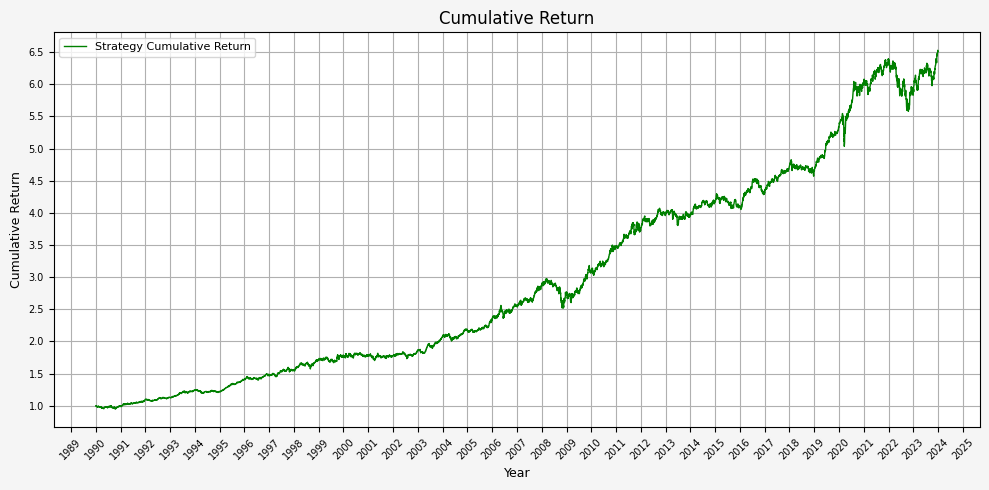

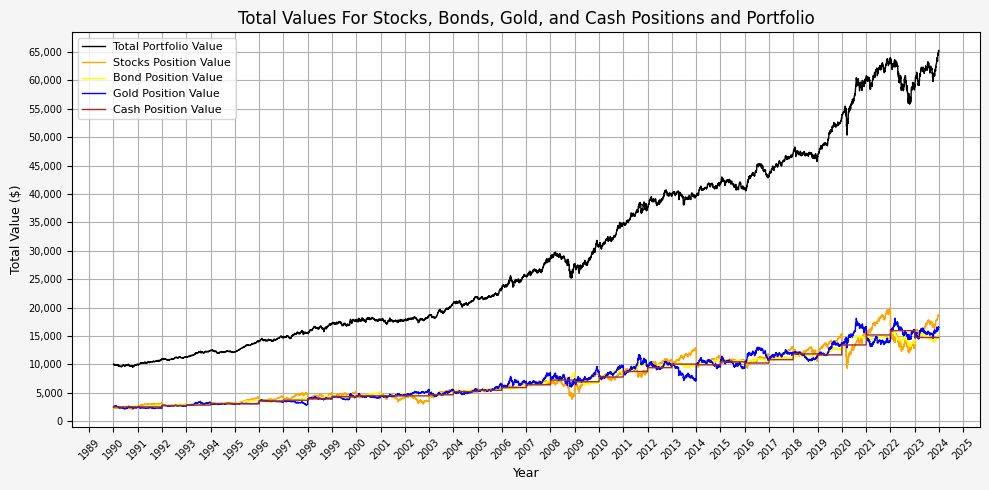

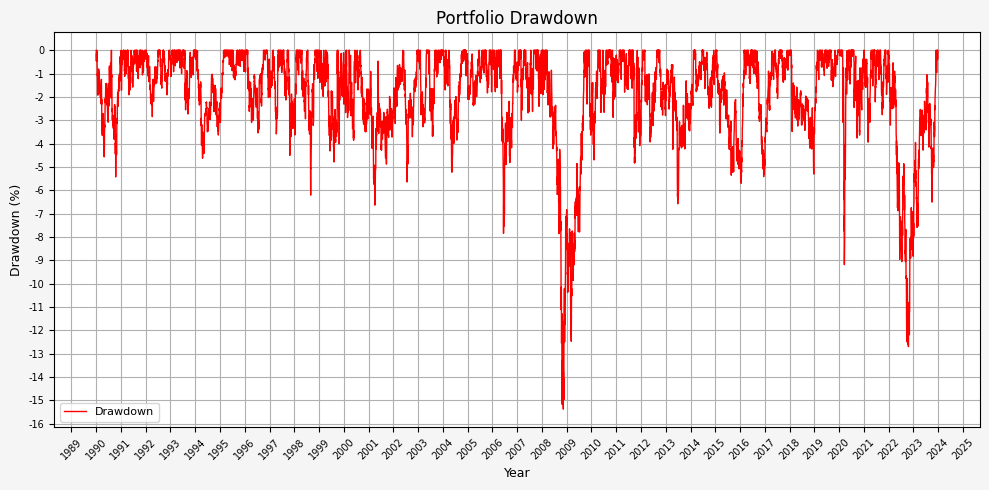

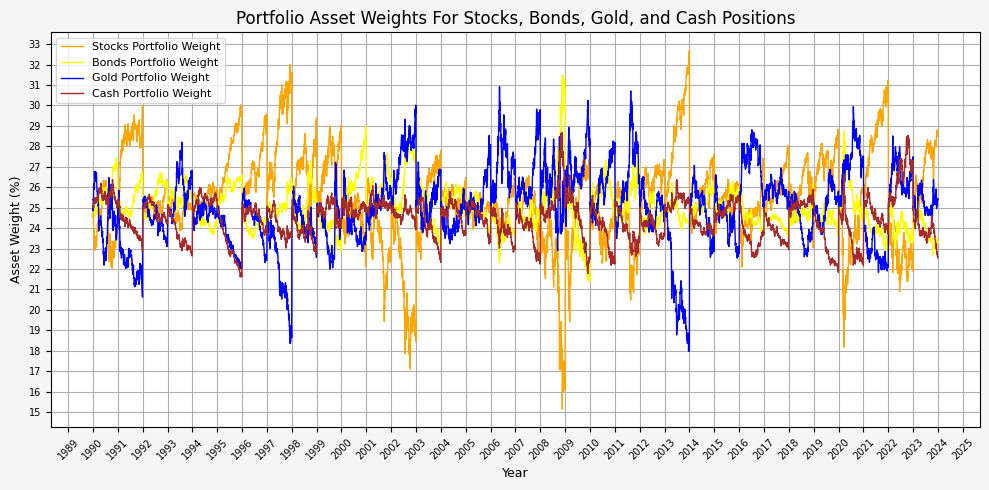

Return
Year          
1991  0.102105
1992  0.030323
1993  0.098695
1994 -0.017222
1995  0.153473
1996  0.048529
1997  0.056127
1998  0.102107
1999  0.039196
2000  0.000025
2001 -0.005315
2002  0.042658
2003  0.120939
2004  0.051419
2005  0.064235
2006  0.104307
2007  0.117139
2008 -0.033383
2009  0.107354
2010  0.136550
2011  0.069683
2012  0.067507
2013 -0.006023
2014  0.052264
2015 -0.018332
2016  0.052463
2017  0.094968
2018 -0.011949
2019  0.145397
2020  0.133985
2021  0.056786
2022 -0.082424
2023  0.108761

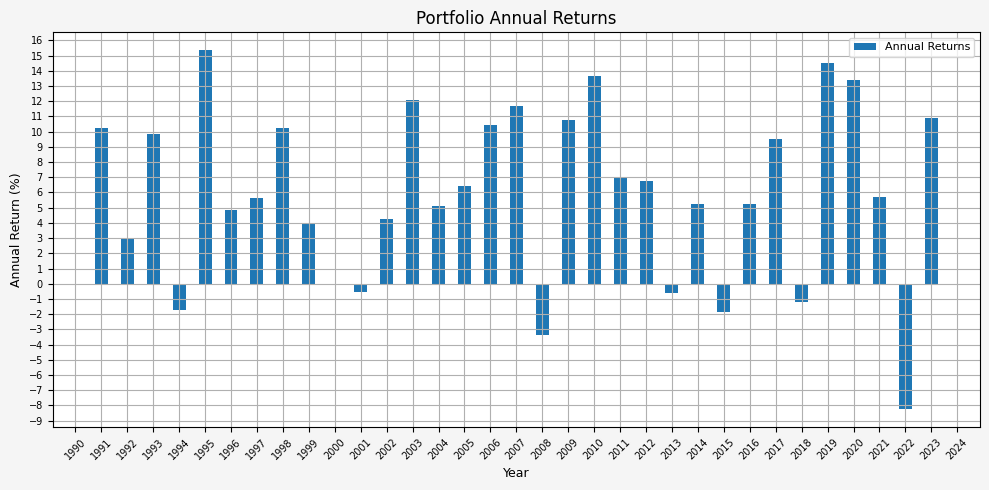

In [21]:
plot_cumulative_return(strat)
plot_values(strat)
plot_drawdown(strat)
plot_asset_weights(strat)

# Create dataframe for the annual returns
strat_annual_returns = strat['Cumulative_Return'].resample('Y').last().pct_change().dropna()
strat_annual_returns_df = strat_annual_returns.to_frame()
strat_annual_returns_df['Year'] = strat_annual_returns_df.index.year  # Add a 'Year' column with just the year
strat_annual_returns_df.reset_index(drop=True, inplace=True)  # Reset the index to remove the datetime index

# Now the DataFrame will have 'Year' and 'Cumulative_Return' columns
strat_annual_returns_df = strat_annual_returns_df[['Year', 'Cumulative_Return']]  # Keep only 'Year' and 'Cumulative_Return' columns
strat_annual_returns_df.rename(columns = {'Cumulative_Return':'Return'}, inplace=True)
strat_annual_returns_df.set_index('Year', inplace=True)
display(strat_annual_returns_df)

plan_name = '_'.join(fund_list)
file = plan_name + "_Annual_Returns.xlsx"
location = file
strat_annual_returns_df.to_excel(location, sheet_name='data')

plot_annual_returns(strat_annual_returns_df)

## Calculate stats for various rebalance dates

In [22]:
# # List of funds to be used
# fund_list = ['Stocks', 'Bonds', 'Gold', 'Cash']

# # Starting cash contribution
# starting_cash = 10000

# # Monthly cash contribution
# cash_contrib = 0

# months = list(range(1, 13))
# days = list(range(1, 28))

# stats = pd.DataFrame(columns = ['Rebal_Month', 'Rebal_Day', 'Annualized Mean', 'Annualized Volatility', 'Annualized Sharpe Ratio', 'CAGR', 
#                                 'Daily Max Return', 'Daily Max Return (Date)', 'Daily Min Return', 'Daily Min Return (Date)', 'Max Drawdown', 
#                                 'Peak', 'Bottom', 'Recovery Date'])

# for month in months:
#     for day in days:
#         strat = strategy(fund_list, starting_cash, cash_contrib, perm_port, month, day).set_index('Date')
#         sum_stats = summary_stats(fund_list, strat[['Return']], 'Daily')
#         stats = pd.concat([stats, sum_stats], ignore_index=True)
#         stats.loc[stats.index[-1], 'Rebal_Month'] = month
#         stats.loc[stats.index[-1], 'Rebal_Day'] = day
#         display(stats)

# plan_name = '_'.join(fund_list)
# file = plan_name + "_All_Summary_Stats.xlsx"
# location = file
# stats.to_excel(location, sheet_name='data')
# print(f"All summary stats complete for {plan_name}.")